# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Sanity Functions

In [2]:
def sanity_check(model, use_softplus=False, transformation_grad=1):

    model_dict = dict(model.state_dict())
    print(model_dict.keys())

    if not use_softplus:
        a = model.transformation.params[transformation_grad].detach().cpu()
        eps = torch.empty_like(a)
        eps[0] = a[0]
        eps[1:] = torch.nn.functional.softplus(a[1:])
        eps = torch.cumsum(eps, dim=0)
    
    is_mono = torch.all(torch.diff(eps) > 0)
    print(is_mono.item())
        
    print(f"{eps}")  # should be strictly increasing
    plt.plot(range(len(eps)), eps, marker='o')
    plt.title("Monotonic spline coefficients ε_j,p")
    plt.xlabel("Basis index p")
    plt.ylabel("ε_j,p")
    plt.show()

def series(x):
    """Return a 1D numpy array from tensor OR list/tuple of (tensors|floats)."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    if isinstance(x, (list, tuple)):
        return np.array([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in x])
    return np.asarray(x)

#### Hyperparameter choice

In [3]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}

# Test 1 ndependence copula + standard Gaussian marginals (N(0,1))

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Independent Copula and add Gaussian marginals.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [4]:
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)


# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

copula_pv_est = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_351990/815319882.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_351990/815319882.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_351990/815319882.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_t

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:
model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4579, grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<04:05,  4.06it/s]

current_loss: tensor(1.4537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:02, 15.99it/s]

current_loss: tensor(1.4256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:38, 25.39it/s]

current_loss: tensor(1.4244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<00:31, 31.08it/s]

current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:01<00:29, 32.44it/s]

current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:01<00:27, 35.07it/s]

current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:28, 33.44it/s]

current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:01<00:27, 35.11it/s]

current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:02<00:27, 33.81it/s]

current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:02<00:26, 35.11it/s]

current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:02<00:24, 37.05it/s]

current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:02<00:26, 34.96it/s]

current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:02<00:28, 32.14it/s]

current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:03<00:28, 32.18it/s]

current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:03<00:27, 32.39it/s]

current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:03<00:29, 30.03it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)


 11%|█▏        | 113/1000 [00:03<00:26, 32.87it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)


 12%|█▏        | 122/1000 [00:03<00:25, 33.79it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)


 13%|█▎        | 130/1000 [00:04<00:26, 32.86it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)


 13%|█▎        | 134/1000 [00:04<00:26, 32.24it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)


 14%|█▍        | 142/1000 [00:04<00:25, 34.11it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)


 15%|█▍        | 147/1000 [00:04<00:24, 35.16it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)


 16%|█▌        | 155/1000 [00:04<00:28, 29.81it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: 

 16%|█▌        | 160/1000 [00:05<00:25, 32.70it/s]

tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<Mean

 16%|█▋        | 165/1000 [00:05<00:28, 29.43it/s]

current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, grad_fn=<MeanBackward0>)
Early Stop at iteration 165 

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [7]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True


output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=16,            # will ramp
                mcmc_sample_val=64,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 5,  # try 5–10
                
                #Optimization method
                beta_kl_start= 3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=2000  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:00<03:16,  1.01it/s]

IMPROVED! Congrats
[1/200] ELBO train=10.3649  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈2.06e+04  tau4=0.592764  rank=20  E_qf_mean≈18.7  E_qf_total≈37.4  tau*E_qf≈22.2  target≈22.2  resid≈-2.06e+04  Δ=-1.10e+03   β_KL=3.00  


  1%|          | 2/200 [00:01<02:56,  1.12it/s]

NOT IMPROVED! Nr. 1
[2/200] ELBO train=0.0643  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈24.1  tau4=0.59537  rank=20  E_qf_mean≈18.6  E_qf_total≈37.3  tau*E_qf≈22.2  target≈22.2  resid≈0.0486  Δ=+2.61e-03   β_KL=2.90  


  2%|▏         | 3/200 [00:02<02:47,  1.18it/s]

NOT IMPROVED! Nr. 2
[3/200] ELBO train=0.0653  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈24.1  tau4=0.597829  rank=20  E_qf_mean≈18.6  E_qf_total≈37.1  tau*E_qf≈22.2  target≈22.2  resid≈0.0457  Δ=+2.46e-03   β_KL=2.80  


  2%|▏         | 4/200 [00:03<02:42,  1.21it/s]

NOT IMPROVED! Nr. 3
[4/200] ELBO train=0.0665  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈24  tau4=0.598063  rank=20  E_qf_mean≈18.5  E_qf_total≈37  tau*E_qf≈22.1  target≈22.2  resid≈0.0432  Δ=+2.33e-04   β_KL=2.70  


  2%|▎         | 5/200 [00:04<02:39,  1.22it/s]

NOT IMPROVED! Nr. 4
[5/200] ELBO train=0.0592  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.9  tau4=0.598491  rank=20  E_qf_mean≈18.4  E_qf_total≈36.9  tau*E_qf≈22.1  target≈22.2  resid≈0.0789  Δ=+4.28e-04   β_KL=2.60  


  3%|▎         | 6/200 [00:05<02:38,  1.23it/s]

NOT IMPROVED! Nr. 5
[6/200] ELBO train=0.0614  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.7  tau4=0.599108  rank=20  E_qf_mean≈18.4  E_qf_total≈36.7  tau*E_qf≈22  target≈22.2  resid≈0.113  Δ=+6.17e-04   β_KL=2.50  


  4%|▎         | 7/200 [00:05<02:36,  1.24it/s]

NOT IMPROVED! Nr. 6
[7/200] ELBO train=0.0594  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0501 σmin=0.0501 σmax=0.0501  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.6  tau4=0.599875  rank=20  E_qf_mean≈18.3  E_qf_total≈36.6  tau*E_qf≈21.9  target≈22.2  resid≈0.14  Δ=+7.67e-04   β_KL=2.40  


  4%|▍         | 8/200 [00:06<02:34,  1.25it/s]

NOT IMPROVED! Nr. 7
[8/200] ELBO train=0.0549  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0501 σmin=0.0501 σmax=0.0501  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.5  tau4=0.600759  rank=20  E_qf_mean≈18.2  E_qf_total≈36.5  tau*E_qf≈21.9  target≈22.2  resid≈0.161  Δ=+8.84e-04   β_KL=2.30  


  4%|▍         | 9/200 [00:07<02:32,  1.25it/s]

NOT IMPROVED! Nr. 8
[9/200] ELBO train=0.0532  val_ELPD=-0.0007  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.01, 0.001]  σ̄=0.0502 σmin=0.0502 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.4  tau4=0.60175  rank=20  E_qf_mean≈18.2  E_qf_total≈36.4  tau*E_qf≈21.9  target≈22.2  resid≈0.18  Δ=+9.91e-04   β_KL=2.20  


  5%|▌         | 10/200 [00:08<02:32,  1.24it/s]

NOT IMPROVED! Nr. 9
[10/200] ELBO train=0.0490  val_ELPD=-0.0008  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0502 σmin=0.0502 σmax=0.0502  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.4  tau4=0.602826  rank=20  E_qf_mean≈18.1  E_qf_total≈36.2  tau*E_qf≈21.8  target≈22.2  resid≈0.195  Δ=+1.08e-03   β_KL=2.10  


  6%|▌         | 11/200 [00:09<02:31,  1.25it/s]

NOT IMPROVED! Nr. 10
[11/200] ELBO train=0.0502  val_ELPD=-0.0008  train_ELPD=-0.0007  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.3  tau4=0.603989  rank=20  E_qf_mean≈18.1  E_qf_total≈36.1  tau*E_qf≈21.8  target≈22.2  resid≈0.21  Δ=+1.16e-03   β_KL=2.00  


  6%|▌         | 12/200 [00:09<02:30,  1.25it/s]

NOT IMPROVED! Nr. 11
[12/200] ELBO train=0.0473  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.2  tau4=0.605162  rank=20  E_qf_mean≈18  E_qf_total≈36.1  tau*E_qf≈21.8  target≈22.2  resid≈0.212  Δ=+1.17e-03   β_KL=1.90  


  6%|▋         | 13/200 [00:10<02:29,  1.25it/s]

NOT IMPROVED! Nr. 12
[13/200] ELBO train=0.0455  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.2  tau4=0.606343  rank=20  E_qf_mean≈18  E_qf_total≈36  tau*E_qf≈21.8  target≈22.2  resid≈0.212  Δ=+1.18e-03   β_KL=1.80  


  7%|▋         | 14/200 [00:11<02:28,  1.25it/s]

NOT IMPROVED! Nr. 13
[14/200] ELBO train=0.0456  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0504 σmin=0.0504 σmax=0.0504  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23.1  tau4=0.607539  rank=20  E_qf_mean≈18  E_qf_total≈35.9  tau*E_qf≈21.8  target≈22.2  resid≈0.215  Δ=+1.20e-03   β_KL=1.70  


  8%|▊         | 15/200 [00:12<02:27,  1.26it/s]

NOT IMPROVED! Nr. 14
[15/200] ELBO train=0.0399  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0504 σmin=0.0504 σmax=0.0504  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23  tau4=0.608739  rank=20  E_qf_mean≈17.9  E_qf_total≈35.8  tau*E_qf≈21.8  target≈22.2  resid≈0.215  Δ=+1.20e-03   β_KL=1.60  


  8%|▊         | 16/200 [00:12<02:26,  1.26it/s]

NOT IMPROVED! Nr. 15
[16/200] ELBO train=0.0404  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈23  tau4=0.609957  rank=20  E_qf_mean≈17.9  E_qf_total≈35.8  tau*E_qf≈21.8  target≈22.2  resid≈0.218  Δ=+1.22e-03   β_KL=1.50  


  8%|▊         | 17/200 [00:13<02:25,  1.26it/s]

NOT IMPROVED! Nr. 16
[17/200] ELBO train=0.0399  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.9  tau4=0.611193  rank=20  E_qf_mean≈17.8  E_qf_total≈35.7  tau*E_qf≈21.8  target≈22.2  resid≈0.22  Δ=+1.24e-03   β_KL=1.40  


  9%|▉         | 18/200 [00:14<02:24,  1.26it/s]

NOT IMPROVED! Nr. 17
[18/200] ELBO train=0.0370  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0505 σmin=0.0505 σmax=0.0505  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.9  tau4=0.612441  rank=20  E_qf_mean≈17.8  E_qf_total≈35.6  tau*E_qf≈21.8  target≈22.2  resid≈0.222  Δ=+1.25e-03   β_KL=1.30  


 10%|▉         | 19/200 [00:15<02:23,  1.26it/s]

NOT IMPROVED! Nr. 18
[19/200] ELBO train=0.0353  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.006999999999999999, 0.0007]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.8  tau4=0.613713  rank=20  E_qf_mean≈17.8  E_qf_total≈35.5  tau*E_qf≈21.8  target≈22.2  resid≈0.226  Δ=+1.27e-03   β_KL=1.20  


 10%|█         | 20/200 [00:16<02:23,  1.26it/s]

NOT IMPROVED! Nr. 19
[20/200] ELBO train=0.0332  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.7  tau4=0.615  rank=20  E_qf_mean≈17.7  E_qf_total≈35.4  tau*E_qf≈21.8  target≈22.2  resid≈0.228  Δ=+1.29e-03   β_KL=1.10  


 10%|█         | 21/200 [00:16<02:22,  1.26it/s]

NOT IMPROVED! Nr. 20
[21/200] ELBO train=0.0316  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.7  tau4=0.616314  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈21.8  target≈22.2  resid≈0.232  Δ=+1.31e-03   β_KL=1.00  


 11%|█         | 22/200 [00:17<02:21,  1.26it/s]

NOT IMPROVED! Nr. 21
[22/200] ELBO train=0.0306  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0506 σmin=0.0506 σmax=0.0506  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.6  tau4=0.617604  rank=20  E_qf_mean≈17.6  E_qf_total≈35.3  tau*E_qf≈21.8  target≈22.2  resid≈0.228  Δ=+1.29e-03   β_KL=1.00  


 12%|█▏        | 23/200 [00:18<02:20,  1.26it/s]

NOT IMPROVED! Nr. 22
[23/200] ELBO train=0.0317  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.6  tau4=0.618884  rank=20  E_qf_mean≈17.6  E_qf_total≈35.2  tau*E_qf≈21.8  target≈22.2  resid≈0.225  Δ=+1.28e-03   β_KL=1.00  


 12%|█▏        | 24/200 [00:19<02:20,  1.26it/s]

NOT IMPROVED! Nr. 23
[24/200] ELBO train=0.0308  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.6  tau4=0.62015  rank=20  E_qf_mean≈17.6  E_qf_total≈35.1  tau*E_qf≈21.8  target≈22.2  resid≈0.222  Δ=+1.27e-03   β_KL=1.00  


 12%|█▎        | 25/200 [00:20<02:19,  1.26it/s]

NOT IMPROVED! Nr. 24
[25/200] ELBO train=0.0324  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.5  tau4=0.621419  rank=20  E_qf_mean≈17.5  E_qf_total≈35.1  tau*E_qf≈21.8  target≈22.2  resid≈0.223  Δ=+1.27e-03   β_KL=1.00  


 13%|█▎        | 26/200 [00:20<02:18,  1.26it/s]

NOT IMPROVED! Nr. 25
[26/200] ELBO train=0.0297  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.5  tau4=0.622674  rank=20  E_qf_mean≈17.5  E_qf_total≈35  tau*E_qf≈21.8  target≈22.2  resid≈0.22  Δ=+1.25e-03   β_KL=1.00  


 14%|█▎        | 27/200 [00:21<02:17,  1.26it/s]

NOT IMPROVED! Nr. 26
[27/200] ELBO train=0.0316  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.4  tau4=0.623939  rank=20  E_qf_mean≈17.5  E_qf_total≈34.9  tau*E_qf≈21.8  target≈22.2  resid≈0.221  Δ=+1.26e-03   β_KL=1.00  


 14%|█▍        | 28/200 [00:22<02:16,  1.26it/s]

NOT IMPROVED! Nr. 27
[28/200] ELBO train=0.0309  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.4  tau4=0.625198  rank=20  E_qf_mean≈17.4  E_qf_total≈34.9  tau*E_qf≈21.8  target≈22.2  resid≈0.22  Δ=+1.26e-03   β_KL=1.00  


 14%|█▍        | 29/200 [00:23<02:15,  1.26it/s]

NOT IMPROVED! Nr. 28
[29/200] ELBO train=0.0302  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.004899999999999999, 0.00049]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.3  tau4=0.626459  rank=20  E_qf_mean≈17.4  E_qf_total≈34.8  tau*E_qf≈21.8  target≈22.2  resid≈0.219  Δ=+1.26e-03   β_KL=1.00  


 15%|█▌        | 30/200 [00:24<02:15,  1.26it/s]

NOT IMPROVED! Nr. 29
[30/200] ELBO train=0.0309  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.003429999999999999, 0.000343]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.3  tau4=0.627732  rank=20  E_qf_mean≈17.4  E_qf_total≈34.7  tau*E_qf≈21.8  target≈22.2  resid≈0.221  Δ=+1.27e-03   β_KL=1.00  


 15%|█▌        | 30/200 [00:24<02:21,  1.20it/s]

NOT IMPROVED! Nr. 30
[31/200] ELBO train=0.0310  val_ELPD=-0.0008  train_ELPD=-0.0008  S_train=16 S_val=64  lr=[0.003429999999999999, 0.000343]  σ̄=0.0508 σmin=0.0508 σmax=0.0508  N=2000 B=2000 B̄≈2000.0  priors/obs: decor≈0 trans≈22.2  tau4=0.629014  rank=20  E_qf_mean≈17.3  E_qf_total≈34.7  tau*E_qf≈21.8  target≈22.2  resid≈0.222  Δ=+1.28e-03   β_KL=1.00  
Early stop @ epoch 31: no val improvement for 30 epochs.


In [8]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.2730,   1.4154,   1.4154,   1.4164,   2.0062,   1.9559,   2.1500,
          2.0940,   3.2053,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)
12
12
Parameter containing:
tensor([-10.6942,   1.0775,   1.0775,   1.0775,   3.4488,   1.7815,   2.1470,
          2.2148,   0.2554,   1.6492,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)
12
12


FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2730,  -8.6402,  -7.0074,  -5.3739,  -3.2414,  -1.1532,   1.1069,
          3.3171,   6.5622,   8.3804,  10.1985,  12.0167])


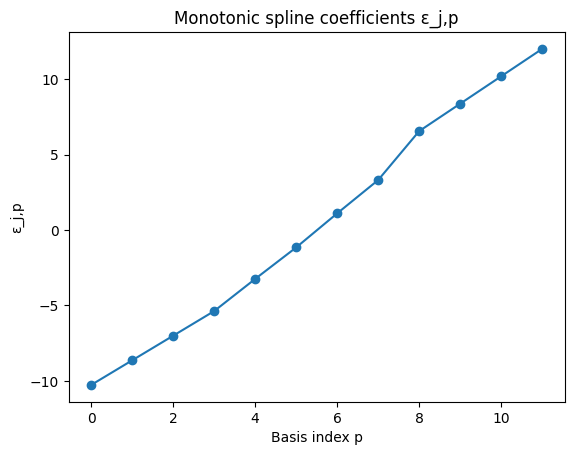

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9900, -8.1802, -6.3536, -4.5438, -2.7340, -0.9242,  0.8856,  2.6954,
         4.5052,  6.3151,  8.1249,  9.9347])


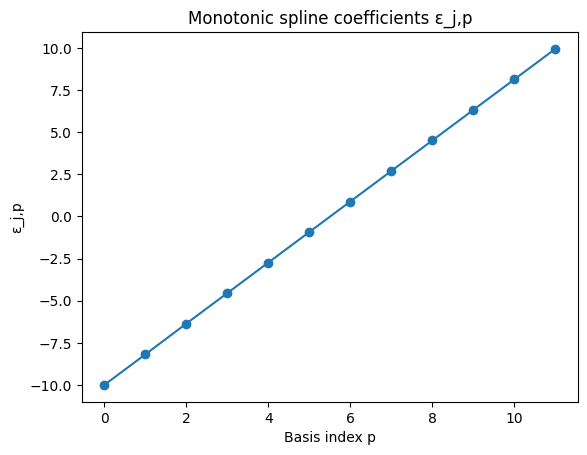

FREQ
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.6942,  -9.3237,  -7.9532,  -6.5827,  -3.1027,  -1.1655,   1.0920,
          3.4104,   4.2394,   6.0645,   7.8827,   9.7008])


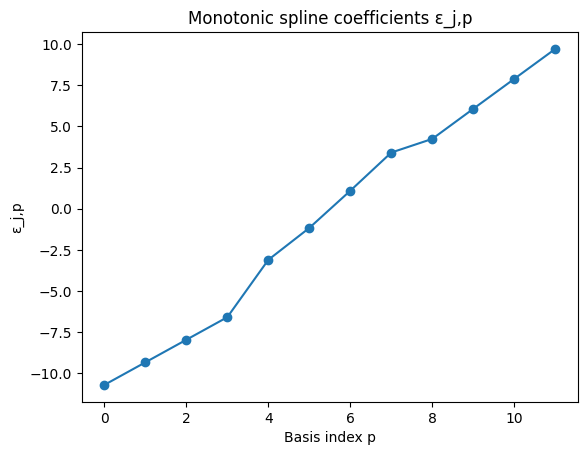

BAY
dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9900, -8.1802, -6.3536, -4.5438, -2.7340, -0.9242,  0.8856,  2.6954,
         4.5052,  6.3151,  8.1249,  9.9347])


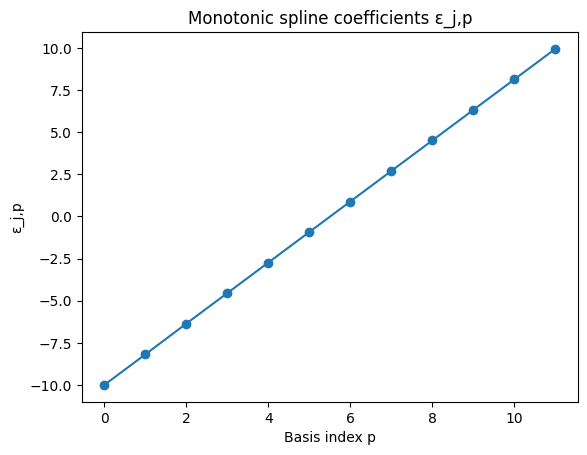

In [9]:
print("FREQ")
sanity_check(model_freq, transformation_grad=0)
print("BAY")
sanity_check(model, transformation_grad=0)
print("FREQ")
sanity_check(model_freq, transformation_grad=1)
print("BAY")
sanity_check(model, transformation_grad=1)

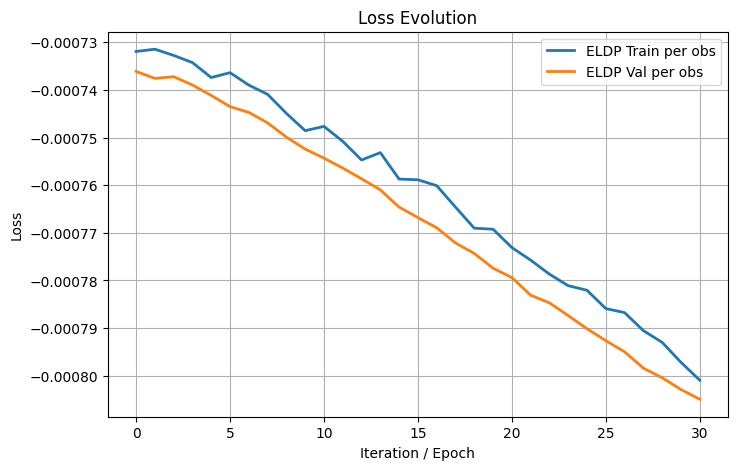

In [14]:
elbo= output['loss_history']
loss_history = output['ll_history']
val_loss = output['val_history']
mean_log_q = output['mean_log_q']
mean_log_p_tilde = output['mean_log_p_tilde']


# Plot            
plt.figure(figsize=(8, 5))
#plt.plot(mean_log_q, label= "mean_log_q per obs")
#plt.plot(mean_log_p_tilde, label= "mean_log_p_tilde per obs")
#plt.plot(elbo, label= "ELBO per obs")
plt.plot(loss_history, label="ELDP Train per obs", linewidth=2)
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(
    "freq_model nr. parameters", sum(p.numel() for p in model_freq.parameters() if p.requires_grad),
    "bay_model nr. parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))

print("VI Model params = ",output['mu'])
print("BGTM params = ",[p for p in model.parameters() if p.requires_grad])
print("GTMp params = ",[p for p in model_freq.parameters() if p.requires_grad])

freq_model nr. parameters 24 bay_model nr. parameters 24
VI Model params =  tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311, -9.9900,  1.6311,  1.6511,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311],
       device='cuda:0')
BGTM params =  [Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([-9.9900,  1.6311,  1.6511,  1.6311,  1.6311,  1.6311,  1.6311,  1.6311,
         1.6311,  1.6311,  1.6311,  1.6311], device='cuda:0',
       requires_grad=True)]
GTMp params =  [Parameter containing:
tensor([-11.7446,   0.2481,   0.2481,   0.2481,   6.2918,   1.5901,   2.2681,
          1.6871,   6.3327,   1.6411,   1.6411,   1.6411], requires_grad=True), Parameter containing:
tensor([-11.4489,   0.4636,   0.4636,   0

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0658
KLD GTM      Train Data:  -0.0036
KLD Gaussian Train Data:  -0.0014
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.0729
KLD GTM      Test  Data:  0.003
KLD Gaussian Test  Data:  0.0012
KLD Copula   Test  Data:  0.0011


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [16]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

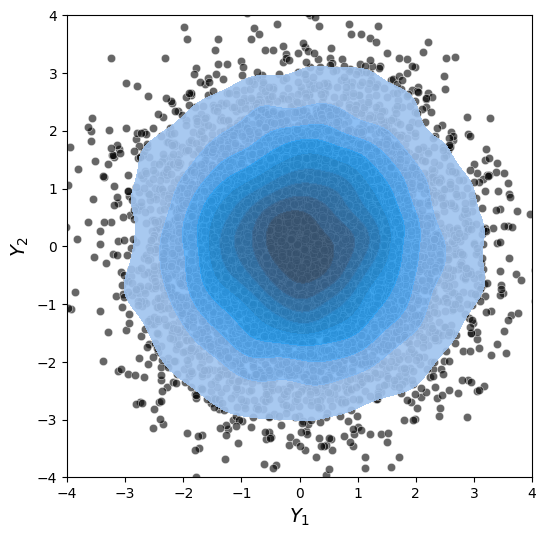

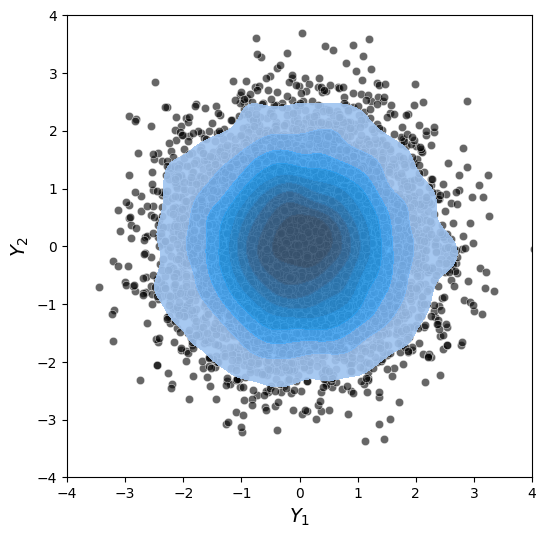

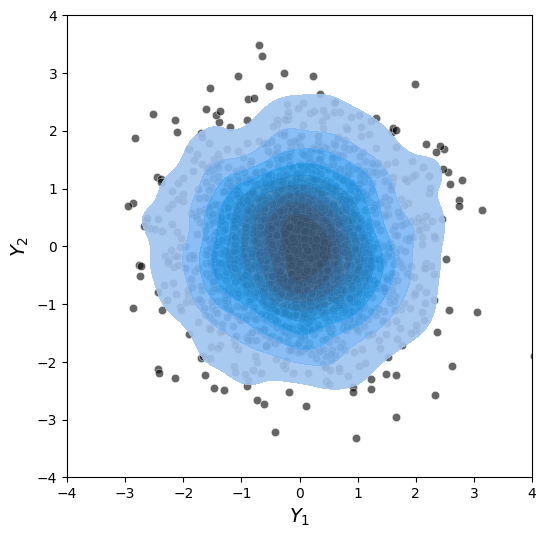

In [17]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

# Test 2
Independence copula + shifted/scaled Gaussian marginals (N(μ, σ²))

In [27]:
# User-chosen marginal parameters
mu = torch.tensor([1.5, -0.7], dtype=torch.float32)
sigma = torch.tensor([1.8, 0.6], dtype=torch.float32)  # stds

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
# Transform uniforms to shifted/scaled Gaussians
Z_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()
simulated_data_train = mu + sigma * Z_train

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
Z_val = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()
simulated_data_validate = mu + sigma * Z_val

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
Z_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()
simulated_data_test = mu + sigma * Z_test

# ---------- "True" log-likelihoods under independence + N(mu, sigma^2) ----------
loglik_true_train = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_train).sum(1)
loglik_true_validate = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_validate).sum(1)
loglik_true_test = torch.distributions.Normal(mu, sigma).log_prob(simulated_data_test).sum(1)

# ---------- "Estimated" marginals from train (fit μ, σ from train) ----------
means = simulated_data_train.mean(0)
stds  = simulated_data_train.std(0, unbiased=True)

loglik_true_est_train = torch.distributions.Normal(means, stds).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means, stds).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means, stds).log_prob(simulated_data_test).sum(1)

# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=300)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=300)

### BGTM model

In [28]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 10,  # try 5–10
                #Optimization method
                beta_kl_start= 1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=300  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:10<35:40, 10.76s/it]

IMPROVED! Congrats
[1/200] train=20916.5639  val_ELPD=-0.0071  train_ELPD-0.0074S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈106  priors/obs: decor≈0 trans≈2.03e+04  tau4=0.600833  rank=20  E_qf_mean≈18.5  E_qf_total≈36.9  tau*E_qf≈22.2  target≈22.2  resid≈-2.03e+04  Δ=-1.10e+03   β_KL=15.00  


  1%|          | 2/200 [00:21<35:17, 10.69s/it]

IMPROVED! Congrats
[2/200] train=579.7225  val_ELPD=-0.0065  train_ELPD-0.0070S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈99.31  priors/obs: decor≈0 trans≈23.6  tau4=0.618095  rank=20  E_qf_mean≈18  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈0.31  Δ=+1.73e-02   β_KL=14.30  


  2%|▏         | 3/200 [00:32<35:05, 10.69s/it]

IMPROVED! Congrats
[3/200] train=551.7579  val_ELPD=-0.0060  train_ELPD-0.0064S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈90.53  priors/obs: decor≈0 trans≈23.3  tau4=0.628478  rank=20  E_qf_mean≈17.7  E_qf_total≈35.3  tau*E_qf≈22.2  target≈22.2  resid≈0.183  Δ=+1.04e-02   β_KL=13.60  


  2%|▏         | 4/200 [00:43<35:21, 10.82s/it]

IMPROVED! Congrats
[4/200] train=529.3653  val_ELPD=-0.0057  train_ELPD-0.0059S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈84.16  priors/obs: decor≈0 trans≈22.8  tau4=0.629253  rank=20  E_qf_mean≈17.4  E_qf_total≈34.9  tau*E_qf≈22  target≈22.2  resid≈0.135  Δ=+7.75e-04   β_KL=12.90  


  2%|▎         | 5/200 [00:53<34:57, 10.76s/it]

IMPROVED! Congrats
[5/200] train=500.9714  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=200 B̄≈285.7  lik/obs≈81.44  priors/obs: decor≈0 trans≈22  tau4=0.630844  rank=20  E_qf_mean≈17.2  E_qf_total≈34.4  tau*E_qf≈21.7  target≈22.2  resid≈0.274  Δ=+1.59e-03   β_KL=12.20  


  3%|▎         | 6/200 [01:04<34:42, 10.74s/it]

NOT IMPROVED! Nr. 1
[6/200] train=470.6545  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0503 σmin=0.0503 σmax=0.0503  N=2000 B=200 B̄≈285.7  lik/obs≈81.16  priors/obs: decor≈0 trans≈21.3  tau4=0.633354  rank=20  E_qf_mean≈16.9  E_qf_total≈33.8  tau*E_qf≈21.4  target≈22.2  resid≈0.425  Δ=+2.51e-03   β_KL=11.50  


  4%|▎         | 7/200 [01:15<34:26, 10.71s/it]

NOT IMPROVED! Nr. 2
[7/200] train=437.7921  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0507 σmin=0.0507 σmax=0.0507  N=2000 B=200 B̄≈285.7  lik/obs≈81.53  priors/obs: decor≈0 trans≈20.8  tau4=0.636383  rank=20  E_qf_mean≈16.7  E_qf_total≈33.5  tau*E_qf≈21.3  target≈22.2  resid≈0.507  Δ=+3.03e-03   β_KL=10.80  


  4%|▍         | 8/200 [01:25<34:11, 10.68s/it]

NOT IMPROVED! Nr. 3
[8/200] train=410.2059  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0510 σmin=0.0510 σmax=0.0510  N=2000 B=200 B̄≈285.7  lik/obs≈81.68  priors/obs: decor≈0 trans≈20.6  tau4=0.639629  rank=20  E_qf_mean≈16.6  E_qf_total≈33.2  tau*E_qf≈21.2  target≈22.2  resid≈0.539  Δ=+3.25e-03   β_KL=10.10  


  4%|▍         | 9/200 [01:36<34:31, 10.84s/it]

NOT IMPROVED! Nr. 4
[9/200] train=383.2123  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0514 σmin=0.0514 σmax=0.0514  N=2000 B=200 B̄≈285.7  lik/obs≈81.6  priors/obs: decor≈0 trans≈20.5  tau4=0.64296  rank=20  E_qf_mean≈16.5  E_qf_total≈33  tau*E_qf≈21.2  target≈22.2  resid≈0.549  Δ=+3.33e-03   β_KL=9.40  


  5%|▌         | 10/200 [01:48<34:34, 10.92s/it]

NOT IMPROVED! Nr. 5
[10/200] train=356.8921  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0517 σmin=0.0517 σmax=0.0517  N=2000 B=200 B̄≈285.7  lik/obs≈81.31  priors/obs: decor≈0 trans≈20.3  tau4=0.646331  rank=20  E_qf_mean≈16.4  E_qf_total≈32.8  tau*E_qf≈21.2  target≈22.2  resid≈0.553  Δ=+3.37e-03   β_KL=8.70  


  6%|▌         | 11/200 [01:59<34:43, 11.02s/it]

IMPROVED! Congrats
[11/200] train=323.6838  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0521 σmin=0.0521 σmax=0.0521  N=2000 B=200 B̄≈285.7  lik/obs≈80.99  priors/obs: decor≈0 trans≈20.3  tau4=0.649736  rank=20  E_qf_mean≈16.3  E_qf_total≈32.6  tau*E_qf≈21.2  target≈22.2  resid≈0.556  Δ=+3.41e-03   β_KL=8.00  


  6%|▌         | 12/200 [02:09<34:12, 10.92s/it]

IMPROVED! Congrats
[12/200] train=302.1937  val_ELPD=-0.0056  train_ELPD-0.0056S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0524 σmin=0.0524 σmax=0.0524  N=2000 B=200 B̄≈285.7  lik/obs≈80.55  priors/obs: decor≈0 trans≈20.2  tau4=0.653202  rank=20  E_qf_mean≈16.2  E_qf_total≈32.4  tau*E_qf≈21.2  target≈22.2  resid≈0.562  Δ=+3.47e-03   β_KL=7.30  


  6%|▋         | 13/200 [02:22<35:26, 11.37s/it]

IMPROVED! Congrats
[13/200] train=273.3463  val_ELPD=-0.0056  train_ELPD-0.0056S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0528 σmin=0.0528 σmax=0.0528  N=2000 B=200 B̄≈285.7  lik/obs≈80.14  priors/obs: decor≈0 trans≈20  tau4=0.656758  rank=20  E_qf_mean≈16.1  E_qf_total≈32.2  tau*E_qf≈21.2  target≈22.2  resid≈0.573  Δ=+3.56e-03   β_KL=6.60  


  7%|▋         | 14/200 [02:35<36:38, 11.82s/it]

IMPROVED! Congrats
[14/200] train=247.1632  val_ELPD=-0.0056  train_ELPD-0.0056S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0532 σmin=0.0532 σmax=0.0532  N=2000 B=200 B̄≈285.7  lik/obs≈79.79  priors/obs: decor≈0 trans≈19.9  tau4=0.660445  rank=20  E_qf_mean≈16  E_qf_total≈32  tau*E_qf≈21.1  target≈22.2  resid≈0.59  Δ=+3.69e-03   β_KL=5.90  


  8%|▊         | 15/200 [02:46<36:04, 11.70s/it]

IMPROVED! Congrats
[15/200] train=217.6589  val_ELPD=-0.0056  train_ELPD-0.0056S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0535 σmin=0.0535 σmax=0.0535  N=2000 B=200 B̄≈285.7  lik/obs≈79.56  priors/obs: decor≈0 trans≈19.7  tau4=0.664321  rank=20  E_qf_mean≈15.9  E_qf_total≈31.7  tau*E_qf≈21.1  target≈22.2  resid≈0.615  Δ=+3.88e-03   β_KL=5.20  


  8%|▊         | 16/200 [02:58<35:44, 11.65s/it]

IMPROVED! Congrats
[16/200] train=193.6117  val_ELPD=-0.0055  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0539 σmin=0.0539 σmax=0.0539  N=2000 B=200 B̄≈285.7  lik/obs≈79.23  priors/obs: decor≈0 trans≈19.5  tau4=0.668448  rank=20  E_qf_mean≈15.7  E_qf_total≈31.5  tau*E_qf≈21  target≈22.2  resid≈0.649  Δ=+4.13e-03   β_KL=4.50  


  8%|▊         | 17/200 [03:09<34:59, 11.47s/it]

IMPROVED! Congrats
[17/200] train=167.3006  val_ELPD=-0.0055  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0543 σmin=0.0543 σmax=0.0543  N=2000 B=200 B̄≈285.7  lik/obs≈78.97  priors/obs: decor≈0 trans≈19.2  tau4=0.67291  rank=20  E_qf_mean≈15.6  E_qf_total≈31.1  tau*E_qf≈20.9  target≈22.2  resid≈0.695  Δ=+4.46e-03   β_KL=3.80  


  9%|▉         | 18/200 [03:19<34:02, 11.22s/it]

IMPROVED! Congrats
[18/200] train=138.8320  val_ELPD=-0.0055  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0546 σmin=0.0546 σmax=0.0546  N=2000 B=200 B̄≈285.7  lik/obs≈78.7  priors/obs: decor≈0 trans≈18.9  tau4=0.67782  rank=20  E_qf_mean≈15.4  E_qf_total≈30.7  tau*E_qf≈20.8  target≈22.2  resid≈0.755  Δ=+4.91e-03   β_KL=3.10  


 10%|▉         | 19/200 [03:31<34:27, 11.42s/it]

IMPROVED! Congrats
[19/200] train=115.0340  val_ELPD=-0.0055  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0550 σmin=0.0550 σmax=0.0550  N=2000 B=200 B̄≈285.7  lik/obs≈78.43  priors/obs: decor≈0 trans≈18.5  tau4=0.683344  rank=20  E_qf_mean≈15.1  E_qf_total≈30.3  tau*E_qf≈20.7  target≈22.2  resid≈0.836  Δ=+5.52e-03   β_KL=2.40  


 10%|█         | 20/200 [03:42<33:34, 11.19s/it]

IMPROVED! Congrats
[20/200] train=88.6864  val_ELPD=-0.0055  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0554 σmin=0.0554 σmax=0.0554  N=2000 B=200 B̄≈285.7  lik/obs≈78.1  priors/obs: decor≈0 trans≈17.9  tau4=0.689726  rank=20  E_qf_mean≈14.9  E_qf_total≈29.7  tau*E_qf≈20.5  target≈22.2  resid≈0.948  Δ=+6.38e-03   β_KL=1.70  


 10%|█         | 21/200 [03:53<33:38, 11.28s/it]

IMPROVED! Congrats
[21/200] train=63.2541  val_ELPD=-0.0054  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0557 σmin=0.0557 σmax=0.0557  N=2000 B=200 B̄≈285.7  lik/obs≈77.84  priors/obs: decor≈0 trans≈17.2  tau4=0.705064  rank=20  E_qf_mean≈14.5  E_qf_total≈29  tau*E_qf≈20.4  target≈22.2  resid≈1.11  Δ=+1.53e-02   β_KL=1.00  


 11%|█         | 22/200 [04:04<33:17, 11.22s/it]

IMPROVED! Congrats
[22/200] train=62.6699  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0560 σmin=0.0560 σmax=0.0560  N=2000 B=200 B̄≈285.7  lik/obs≈77.54  priors/obs: decor≈0 trans≈16.3  tau4=0.722565  rank=20  E_qf_mean≈14  E_qf_total≈28  tau*E_qf≈20.2  target≈22.2  resid≈1.23  Δ=+1.75e-02   β_KL=1.00  


 12%|█▏        | 23/200 [04:20<37:10, 12.60s/it]

IMPROVED! Congrats
[23/200] train=61.4209  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0564 σmin=0.0564 σmax=0.0564  N=2000 B=200 B̄≈285.7  lik/obs≈77.24  priors/obs: decor≈0 trans≈15.3  tau4=0.742748  rank=20  E_qf_mean≈13.5  E_qf_total≈27  tau*E_qf≈20  target≈22.2  resid≈1.36  Δ=+2.02e-02   β_KL=1.00  


 12%|█▏        | 24/200 [04:37<40:26, 13.78s/it]

IMPROVED! Congrats
[24/200] train=60.2403  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0567 σmin=0.0567 σmax=0.0567  N=2000 B=200 B̄≈285.7  lik/obs≈77.01  priors/obs: decor≈0 trans≈14.3  tau4=0.765689  rank=20  E_qf_mean≈12.9  E_qf_total≈25.9  tau*E_qf≈19.8  target≈22.2  resid≈1.48  Δ=+2.29e-02   β_KL=1.00  


 12%|█▎        | 25/200 [04:55<43:39, 14.97s/it]

IMPROVED! Congrats
[25/200] train=58.7681  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0570 σmin=0.0570 σmax=0.0570  N=2000 B=200 B̄≈285.7  lik/obs≈76.86  priors/obs: decor≈0 trans≈13.2  tau4=0.791317  rank=20  E_qf_mean≈12.4  E_qf_total≈24.8  tau*E_qf≈19.7  target≈22.2  resid≈1.59  Δ=+2.56e-02   β_KL=1.00  


 13%|█▎        | 26/200 [05:07<41:04, 14.16s/it]

NOT IMPROVED! Nr. 1
[26/200] train=57.8965  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0573 σmin=0.0573 σmax=0.0573  N=2000 B=200 B̄≈285.7  lik/obs≈76.74  priors/obs: decor≈0 trans≈12.2  tau4=0.819519  rank=20  E_qf_mean≈11.9  E_qf_total≈23.8  tau*E_qf≈19.5  target≈22.2  resid≈1.68  Δ=+2.82e-02   β_KL=1.00  


 14%|█▎        | 27/200 [05:18<37:58, 13.17s/it]

NOT IMPROVED! Nr. 2
[27/200] train=56.4419  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0577 σmin=0.0577 σmax=0.0577  N=2000 B=200 B̄≈285.7  lik/obs≈76.77  priors/obs: decor≈0 trans≈11.1  tau4=0.850147  rank=20  E_qf_mean≈11.4  E_qf_total≈22.8  tau*E_qf≈19.4  target≈22.2  resid≈1.75  Δ=+3.06e-02   β_KL=1.00  


 14%|█▍        | 28/200 [05:28<35:35, 12.42s/it]

NOT IMPROVED! Nr. 3
[28/200] train=55.3160  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0580 σmin=0.0580 σmax=0.0580  N=2000 B=200 B̄≈285.7  lik/obs≈76.84  priors/obs: decor≈0 trans≈10.1  tau4=0.883165  rank=20  E_qf_mean≈10.9  E_qf_total≈21.9  tau*E_qf≈19.3  target≈22.2  resid≈1.8  Δ=+3.30e-02   β_KL=1.00  


 14%|█▍        | 29/200 [05:40<34:44, 12.19s/it]

NOT IMPROVED! Nr. 4
[29/200] train=54.1922  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0583 σmin=0.0583 σmax=0.0583  N=2000 B=200 B̄≈285.7  lik/obs≈77.05  priors/obs: decor≈0 trans≈9.08  tau4=0.918507  rank=20  E_qf_mean≈10.5  E_qf_total≈20.9  tau*E_qf≈19.2  target≈22.2  resid≈1.85  Δ=+3.53e-02   β_KL=1.00  


 15%|█▌        | 30/200 [05:52<34:12, 12.07s/it]

NOT IMPROVED! Nr. 5
[30/200] train=53.2105  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0587 σmin=0.0587 σmax=0.0587  N=2000 B=200 B̄≈285.7  lik/obs≈77.22  priors/obs: decor≈0 trans≈8.06  tau4=0.956182  rank=20  E_qf_mean≈10  E_qf_total≈20.1  tau*E_qf≈19.2  target≈22.2  resid≈1.89  Δ=+3.77e-02   β_KL=1.00  


 16%|█▌        | 31/200 [06:08<37:08, 13.19s/it]

NOT IMPROVED! Nr. 6
[31/200] train=51.5514  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0590 σmin=0.0590 σmax=0.0590  N=2000 B=200 B̄≈285.7  lik/obs≈77.41  priors/obs: decor≈0 trans≈7.03  tau4=0.996198  rank=20  E_qf_mean≈9.6  E_qf_total≈19.2  tau*E_qf≈19.1  target≈22.2  resid≈1.92  Δ=+4.00e-02   β_KL=1.00  


 16%|█▌        | 32/200 [06:38<51:16, 18.31s/it]

NOT IMPROVED! Nr. 7
[32/200] train=51.3374  val_ELPD=-0.0054  train_ELPD-0.0054S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0593 σmin=0.0593 σmax=0.0594  N=2000 B=200 B̄≈285.7  lik/obs≈77.62  priors/obs: decor≈0 trans≈6.01  tau4=1.03871  rank=20  E_qf_mean≈9.18  E_qf_total≈18.4  tau*E_qf≈19.1  target≈22.2  resid≈1.95  Δ=+4.25e-02   β_KL=1.00  


 16%|█▋        | 33/200 [06:56<50:46, 18.24s/it]

NOT IMPROVED! Nr. 8
[33/200] train=50.0167  val_ELPD=-0.0054  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0597 σmin=0.0597 σmax=0.0597  N=2000 B=200 B̄≈285.7  lik/obs≈77.91  priors/obs: decor≈0 trans≈4.98  tau4=1.08375  rank=20  E_qf_mean≈8.78  E_qf_total≈17.6  tau*E_qf≈19  target≈22.2  resid≈1.98  Δ=+4.50e-02   β_KL=1.00  


 17%|█▋        | 34/200 [07:07<44:08, 15.95s/it]

NOT IMPROVED! Nr. 9
[34/200] train=48.6857  val_ELPD=-0.0054  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0600 σmin=0.0600 σmax=0.0600  N=2000 B=200 B̄≈285.7  lik/obs≈78.21  priors/obs: decor≈0 trans≈3.96  tau4=1.1315  rank=20  E_qf_mean≈8.39  E_qf_total≈16.8  tau*E_qf≈19  target≈22.2  resid≈2  Δ=+4.78e-02   β_KL=1.00  


 18%|█▊        | 35/200 [07:17<39:39, 14.42s/it]

NOT IMPROVED! Nr. 10
[35/200] train=47.4696  val_ELPD=-0.0055  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.01, 0.001]  σ̄=0.0604 σmin=0.0603 σmax=0.0604  N=2000 B=200 B̄≈285.7  lik/obs≈78.61  priors/obs: decor≈0 trans≈2.94  tau4=1.18222  rank=20  E_qf_mean≈8.01  E_qf_total≈16  tau*E_qf≈18.9  target≈22.2  resid≈2.03  Δ=+5.07e-02   β_KL=1.00  


 18%|█▊        | 36/200 [07:28<36:35, 13.39s/it]

NOT IMPROVED! Nr. 11
[36/200] train=46.6113  val_ELPD=-0.0055  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0607 σmin=0.0607 σmax=0.0607  N=2000 B=200 B̄≈285.7  lik/obs≈78.92  priors/obs: decor≈0 trans≈1.91  tau4=1.23617  rank=20  E_qf_mean≈7.64  E_qf_total≈15.3  tau*E_qf≈18.9  target≈22.2  resid≈2.06  Δ=+5.40e-02   β_KL=1.00  


 18%|█▊        | 37/200 [07:39<34:25, 12.67s/it]

NOT IMPROVED! Nr. 12
[37/200] train=45.7759  val_ELPD=-0.0055  train_ELPD-0.0055S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0610 σmin=0.0609 σmax=0.0610  N=2000 B=200 B̄≈285.7  lik/obs≈79.21  priors/obs: decor≈0 trans≈1.08  tau4=1.29179  rank=20  E_qf_mean≈7.33  E_qf_total≈14.7  tau*E_qf≈18.9  target≈22.2  resid≈2.04  Δ=+5.56e-02   β_KL=1.00  


 19%|█▉        | 38/200 [07:50<32:51, 12.17s/it]

NOT IMPROVED! Nr. 13
[38/200] train=45.1426  val_ELPD=-0.0055  train_ELPD-0.0056S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0612 σmin=0.0612 σmax=0.0612  N=2000 B=200 B̄≈285.7  lik/obs≈79.46  priors/obs: decor≈0 trans≈0.48  tau4=1.34701  rank=20  E_qf_mean≈7.08  E_qf_total≈14.2  tau*E_qf≈19.1  target≈22.2  resid≈1.95  Δ=+5.52e-02   β_KL=1.00  


 20%|█▉        | 39/200 [08:01<31:41, 11.81s/it]

NOT IMPROVED! Nr. 14
[39/200] train=43.9653  val_ELPD=-0.0056  train_ELPD-0.0056S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0615 σmin=0.0614 σmax=0.0615  N=2000 B=200 B̄≈285.7  lik/obs≈79.88  priors/obs: decor≈0 trans≈-0.141  tau4=1.40273  rank=20  E_qf_mean≈6.83  E_qf_total≈13.7  tau*E_qf≈19.2  target≈22.2  resid≈1.9  Δ=+5.57e-02   β_KL=1.00  


 20%|██        | 40/200 [08:12<30:27, 11.42s/it]

NOT IMPROVED! Nr. 15
[40/200] train=43.5765  val_ELPD=-0.0056  train_ELPD-0.0056S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0617 σmin=0.0617 σmax=0.0617  N=2000 B=200 B̄≈285.7  lik/obs≈80.08  priors/obs: decor≈0 trans≈-0.775  tau4=1.45958  rank=20  E_qf_mean≈6.58  E_qf_total≈13.2  tau*E_qf≈19.2  target≈22.2  resid≈1.87  Δ=+5.68e-02   β_KL=1.00  


 20%|██        | 41/200 [08:22<29:32, 11.15s/it]

NOT IMPROVED! Nr. 16
[41/200] train=42.6047  val_ELPD=-0.0056  train_ELPD-0.0056S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0619 σmin=0.0619 σmax=0.0620  N=2000 B=200 B̄≈285.7  lik/obs≈80.46  priors/obs: decor≈0 trans≈-1.42  tau4=1.51829  rank=20  E_qf_mean≈6.33  E_qf_total≈12.7  tau*E_qf≈19.2  target≈22.2  resid≈1.86  Δ=+5.87e-02   β_KL=1.00  


 21%|██        | 42/200 [08:33<28:59, 11.01s/it]

NOT IMPROVED! Nr. 17
[42/200] train=41.6916  val_ELPD=-0.0056  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0622 σmin=0.0622 σmax=0.0622  N=2000 B=200 B̄≈285.7  lik/obs≈80.8  priors/obs: decor≈0 trans≈-2.07  tau4=1.57946  rank=20  E_qf_mean≈6.08  E_qf_total≈12.2  tau*E_qf≈19.2  target≈22.2  resid≈1.86  Δ=+6.12e-02   β_KL=1.00  


 22%|██▏       | 43/200 [08:44<28:23, 10.85s/it]

NOT IMPROVED! Nr. 18
[43/200] train=41.3203  val_ELPD=-0.0056  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0624 σmin=0.0624 σmax=0.0625  N=2000 B=200 B̄≈285.7  lik/obs≈81.16  priors/obs: decor≈0 trans≈-2.73  tau4=1.64372  rank=20  E_qf_mean≈5.84  E_qf_total≈11.7  tau*E_qf≈19.2  target≈22.2  resid≈1.88  Δ=+6.43e-02   β_KL=1.00  


 22%|██▏       | 44/200 [08:54<27:54, 10.74s/it]

NOT IMPROVED! Nr. 19
[44/200] train=41.1031  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0627 σmin=0.0627 σmax=0.0627  N=2000 B=200 B̄≈285.7  lik/obs≈81.54  priors/obs: decor≈0 trans≈-3.4  tau4=1.71165  rank=20  E_qf_mean≈5.6  E_qf_total≈11.2  tau*E_qf≈19.2  target≈22.2  resid≈1.9  Δ=+6.79e-02   β_KL=1.00  


 22%|██▏       | 44/200 [09:05<32:13, 12.39s/it]

NOT IMPROVED! Nr. 20
[45/200] train=39.5944  val_ELPD=-0.0057  train_ELPD-0.0057S_train=32 S_val=128  lr=[0.006999999999999999, 0.0007]  σ̄=0.0629 σmin=0.0629 σmax=0.0630  N=2000 B=200 B̄≈285.7  lik/obs≈81.88  priors/obs: decor≈0 trans≈-4.06  tau4=1.78362  rank=20  E_qf_mean≈5.36  E_qf_total≈10.7  tau*E_qf≈19.1  target≈22.2  resid≈1.93  Δ=+7.20e-02   β_KL=1.00  
Early stop @ epoch 45: no val improvement for 20 epochs.


### GTM model

In [29]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 1/1000 [00:00<02:29,  6.69it/s]

current_loss: tensor(2.1954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5098,

  0%|          | 3/1000 [00:00<02:14,  7.42it/s]

current_loss: tensor(1.5237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4764,

  0%|          | 4/1000 [00:00<02:17,  7.26it/s]

current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4668,

  0%|          | 5/1000 [00:00<02:22,  6.98it/s]

current_loss: tensor(1.5012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4373,

  1%|          | 7/1000 [00:00<02:19,  7.11it/s]

current_loss: tensor(1.4766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4677,

  1%|          | 8/1000 [00:01<02:17,  7.22it/s]

current_loss: tensor(1.5007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5001,

  1%|          | 10/1000 [00:01<02:19,  7.11it/s]

current_loss: tensor(1.4766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4664,

  1%|          | 11/1000 [00:01<02:16,  7.26it/s]

current_loss: tensor(1.4639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4343,

  1%|▏         | 13/1000 [00:01<02:15,  7.31it/s]

current_loss: tensor(1.4762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5006, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4656,

  1%|▏         | 14/1000 [00:01<02:13,  7.37it/s]

current_loss: tensor(1.5003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4332,

  2%|▏         | 16/1000 [00:02<02:12,  7.44it/s]

current_loss: tensor(1.4751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4660,

  2%|▏         | 18/1000 [00:02<02:11,  7.49it/s]

current_loss: tensor(1.4998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4327, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4318,

  2%|▏         | 19/1000 [00:02<02:11,  7.48it/s]

current_loss: tensor(1.4649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4643,

  2%|▏         | 21/1000 [00:02<02:09,  7.54it/s]

current_loss: tensor(1.4324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4321, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4722,

  2%|▏         | 22/1000 [00:02<02:09,  7.54it/s]

current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4998, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4629,

  2%|▏         | 23/1000 [00:03<02:18,  7.03it/s]

current_loss: tensor(1.4316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4718,

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.0623,  -8.2907,  -6.5191,  -4.7475,  -2.9791,  -1.4284,  -0.1668,
          0.9011,   2.3230,   4.0315,   5.8492,   7.6674])


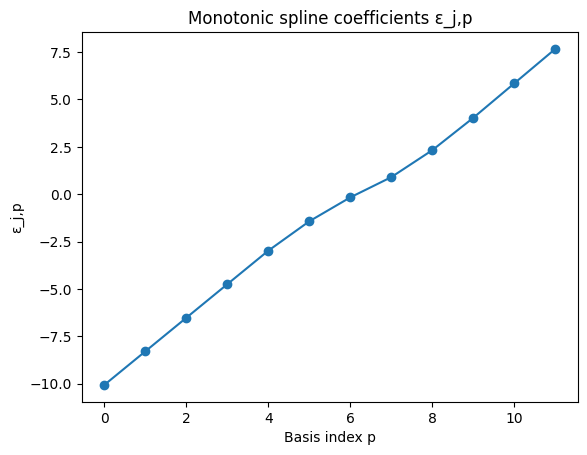

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.0693, -7.9521, -5.9634, -4.4291, -2.9845, -1.5772, -0.2721,  0.8728,
         1.7990,  2.5695,  3.3098,  4.0477])


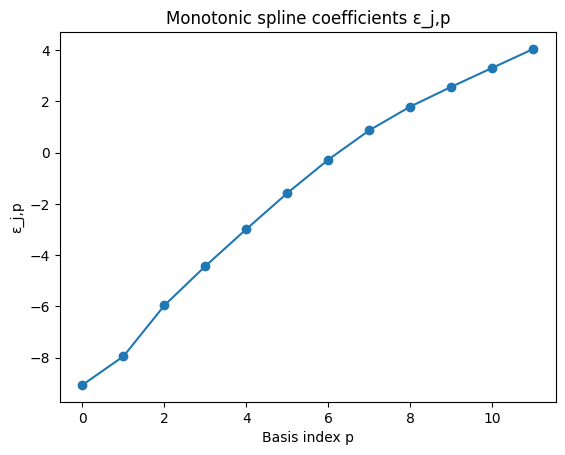

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-10.2783,  -8.6500,  -7.0216,  -5.3933,  -3.7465,  -0.7911,   3.0499,
          5.0022,   6.8206,   8.6388,  10.4570,  12.2752])


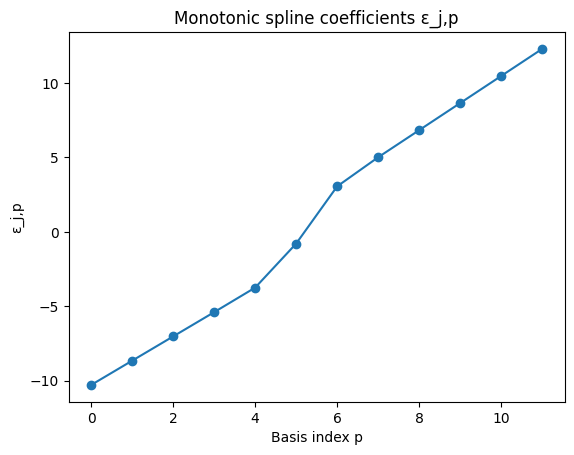

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.9142, -7.9377, -5.6114, -4.3755, -3.1629, -0.5747,  2.0467,  2.8840,
         3.6279,  4.3774,  5.1223,  5.8610])


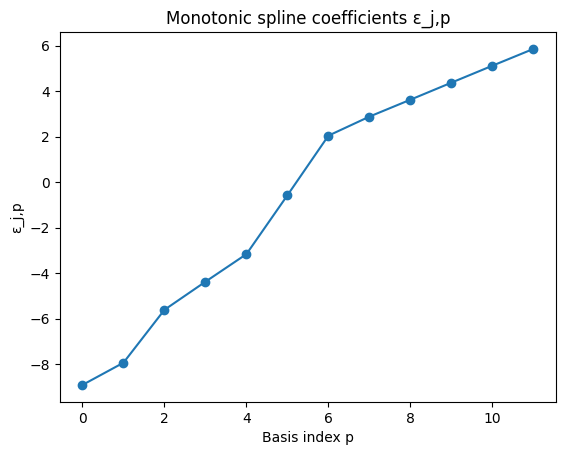

In [30]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

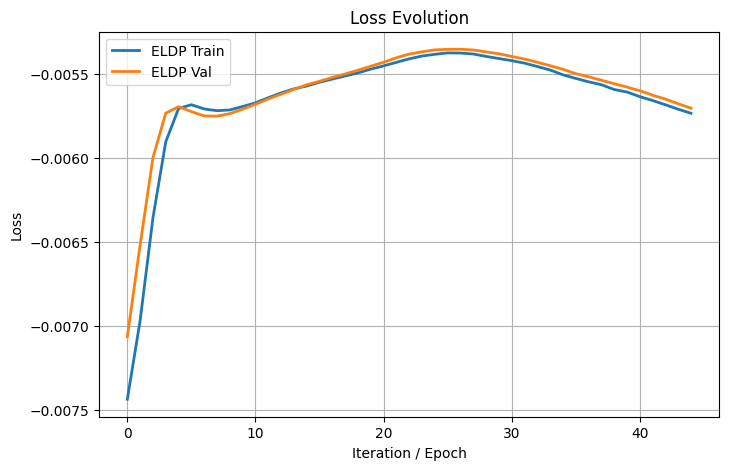

In [31]:
loss_history = output['ll_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Train", linewidth=2)
plt.plot(val_loss, label="ELDP Val", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [33]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [34]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1383
KLD GTM      Train Data:  0.0117
KLD Gaussian Train Data:  -0.0003
KLD Copula   Train Data:  -0.0003

KLD BGTM      Test  Data:  0.1461
KLD GTM      Test  Data:  0.0127
KLD Gaussian Test  Data:  0.0004
KLD Copula   Test  Data:  0.0003


In [35]:
#model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1275: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


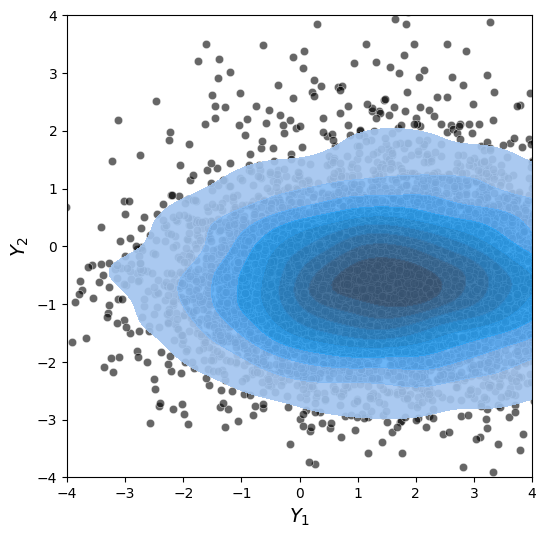

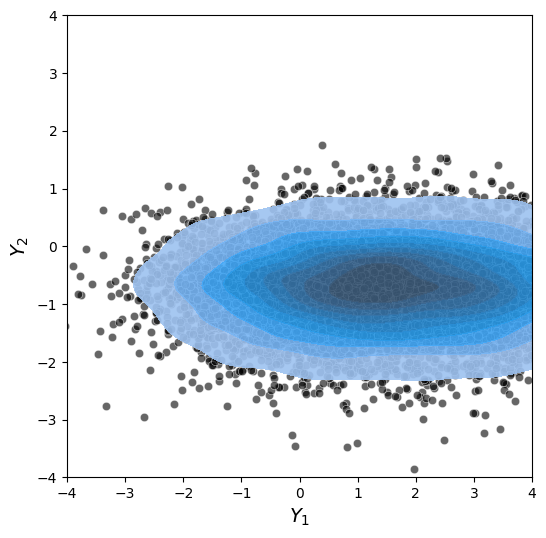

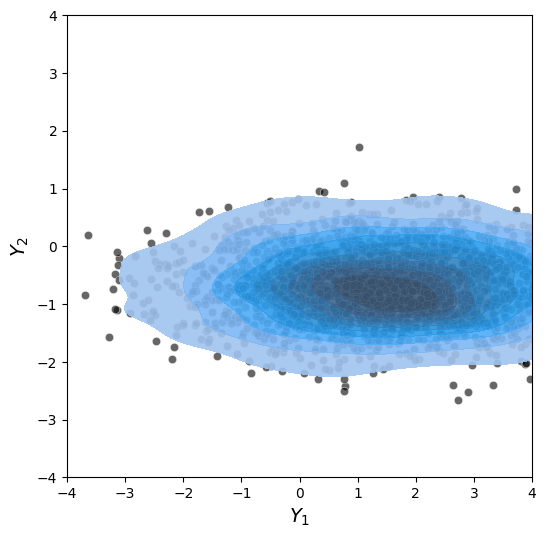

In [36]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

### Independence copula + two-component Gaussian mixture marginals (non-Gaussian)

In [24]:
import numpy as np
import torch
import pyvinecopulib as pv

# Mixture parameters per dimension (same weights across dims for simplicity)
w1 = 0.35  # w2 = 1 - w1
means = torch.tensor([[-2.0,  1.0],   # component 1 means per dim
                      [ 2.0, -1.0]],  # component 2 means per dim
                     dtype=torch.float32)
stds  = torch.tensor([[0.8, 0.5],
                      [0.6, 0.9]], dtype=torch.float32)

def gm2_icdf(u, w1, m, s):
    """
    u: [N, D] tensor in (0,1); w1 scalar; m,s: shape [2, D]
    Returns x: [N, D]
    """
    w2 = 1.0 - w1
    x = torch.empty_like(u)
    mask1 = (u < w1)
    u1 = torch.where(mask1, u / w1, torch.tensor(0.5, dtype=u.dtype))
    u2 = torch.where(~mask1, (u - w1) / w2, torch.tensor(0.5, dtype=u.dtype))
    # invert per dim
    for d in range(u.shape[1]):
        x1 = torch.distributions.Normal(m[0, d], s[0, d]).icdf(u1[:, d])
        x2 = torch.distributions.Normal(m[1, d], s[1, d]).icdf(u2[:, d])
        x[:, d] = torch.where(mask1[:, d], x1, x2)
    return x

def gm2_logpdf(x, w1, m, s):
    w2 = 1.0 - w1
    lp = torch.zeros(x.shape[0])
    for d in range(x.shape[1]):
        lp1 = torch.distributions.Normal(m[0, d], s[0, d]).log_prob(x[:, d])
        lp2 = torch.distributions.Normal(m[1, d], s[1, d]).log_prob(x[:, d])
        # log( w1*e^lp1 + w2*e^lp2 )
        a = torch.stack([lp1 + np.log(w1), lp2 + np.log(w2)], dim=1)
        lp += torch.logsumexp(a, dim=1)
    return lp

# ---------- Copula ----------
copula_pv = pv.Bicop(family=pv.BicopFamily.indep)

# ---------- Train ----------
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
U_train = torch.tensor(simulated_data_uniform_train).float()
simulated_data_train = gm2_icdf(U_train, w1, means, stds)

# ---------- Validate ----------
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
U_val = torch.tensor(simulated_data_uniform_validate).float()
simulated_data_validate = gm2_icdf(U_val, w1, means, stds)

# ---------- Test ----------
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
U_test = torch.tensor(simulated_data_uniform_test).float()
simulated_data_test = gm2_icdf(U_test, w1, means, stds)

# ---------- "True" log-likelihoods under independence + GM(2) marginals ----------
loglik_true_train = gm2_logpdf(simulated_data_train, w1, means, stds)
loglik_true_validate = gm2_logpdf(simulated_data_validate, w1, means, stds)
loglik_true_test = gm2_logpdf(simulated_data_test, w1, means, stds)

# ---------- (Optional) crude "estimated" marginals ----------
# For mixtures, proper estimation needs EM or VI. If you just want a baseline,
# you could (very crudely) fit a single Gaussian to each dim:
means_est = simulated_data_train.mean(0)
stds_est  = simulated_data_train.std(0, unbiased=True)
loglik_true_est_train = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_train).sum(1)
loglik_true_est_validate = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_validate).sum(1)
loglik_true_est_test = torch.distributions.Normal(means_est, stds_est).log_prob(simulated_data_test).sum(1)
# (Use only as a rough reference; your transformation layer should beat this.)


In [25]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=50)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=50)

# BGTM

In [43]:
model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True

output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.5,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=8, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 10,  # try 5–10
                #Optimization method
                beta_kl_start= 1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


First 30 param keys: ['transformation.params.0', 'transformation.params.1']


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=100  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:05<18:42,  5.64s/it]

IMPROVED! Congrats
[1/200] ELBO train=198.9778  val_ELPD=-0.0206  train_ELPD=-0.0209  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈1.97e+04  tau4=0.618807  rank=20  E_qf_mean≈17.9  E_qf_total≈35.9  tau*E_qf≈22.2  target≈22.2  resid≈-1.97e+04  Δ=-1.10e+03   β_KL=3.00  


  1%|          | 2/200 [00:15<26:33,  8.05s/it]

IMPROVED! Congrats
[2/200] ELBO train=1.7161  val_ELPD=-0.0195  train_ELPD=-0.0200  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈22.2  tau4=0.66722  rank=20  E_qf_mean≈16.6  E_qf_total≈33.3  tau*E_qf≈22.2  target≈22.2  resid≈0.805  Δ=+4.84e-02   β_KL=2.87  


  2%|▏         | 3/200 [00:19<20:08,  6.13s/it]

IMPROVED! Congrats
[3/200] ELBO train=1.6267  val_ELPD=-0.0191  train_ELPD=-0.0194  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈20.7  tau4=0.702746  rank=20  E_qf_mean≈15.8  E_qf_total≈31.6  tau*E_qf≈22.2  target≈22.2  resid≈0.561  Δ=+3.55e-02   β_KL=2.73  


  2%|▏         | 4/200 [00:23<17:06,  5.24s/it]

IMPROVED! Congrats
[4/200] ELBO train=1.5631  val_ELPD=-0.0188  train_ELPD=-0.0190  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈18.9  tau4=0.707304  rank=20  E_qf_mean≈14.8  E_qf_total≈29.7  tau*E_qf≈21  target≈22.2  resid≈0.676  Δ=+4.56e-03   β_KL=2.60  


  2%|▎         | 5/200 [00:26<15:24,  4.74s/it]

IMPROVED! Congrats
[5/200] ELBO train=1.4793  val_ELPD=-0.0187  train_ELPD=-0.0188  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈16.6  tau4=0.72652  rank=20  E_qf_mean≈13.8  E_qf_total≈27.6  tau*E_qf≈20.1  target≈22.2  resid≈1.33  Δ=+1.92e-02   β_KL=2.47  


  3%|▎         | 6/200 [00:30<14:22,  4.44s/it]

IMPROVED! Congrats
[6/200] ELBO train=1.3732  val_ELPD=-0.0186  train_ELPD=-0.0187  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0551 σmin=0.0551 σmax=0.0551  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈14.6  tau4=0.752837  rank=20  E_qf_mean≈12.9  E_qf_total≈25.9  tau*E_qf≈19.5  target≈22.2  resid≈1.7  Δ=+2.63e-02   β_KL=2.33  


  4%|▎         | 7/200 [00:34<13:41,  4.25s/it]

IMPROVED! Congrats
[7/200] ELBO train=1.2580  val_ELPD=-0.0186  train_ELPD=-0.0186  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0607 σmin=0.0607 σmax=0.0607  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈13.5  tau4=0.781584  rank=20  E_qf_mean≈12.4  E_qf_total≈24.8  tau*E_qf≈19.4  target≈22.2  resid≈1.78  Δ=+2.87e-02   β_KL=2.20  


  4%|▍         | 8/200 [00:38<13:13,  4.13s/it]

IMPROVED! Congrats
[8/200] ELBO train=1.1614  val_ELPD=-0.0185  train_ELPD=-0.0186  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0668 σmin=0.0668 σmax=0.0669  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈12.4  tau4=0.812286  rank=20  E_qf_mean≈11.9  E_qf_total≈23.7  tau*E_qf≈19.3  target≈22.2  resid≈1.82  Δ=+3.07e-02   β_KL=2.07  


  4%|▍         | 9/200 [00:42<13:00,  4.08s/it]

IMPROVED! Congrats
[9/200] ELBO train=1.0514  val_ELPD=-0.0185  train_ELPD=-0.0186  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0735 σmin=0.0733 σmax=0.0735  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈11.1  tau4=0.845933  rank=20  E_qf_mean≈11.3  E_qf_total≈22.6  tau*E_qf≈19.2  target≈22.2  resid≈1.9  Δ=+3.36e-02   β_KL=1.93  


  5%|▌         | 10/200 [00:46<12:43,  4.02s/it]

NOT IMPROVED! Nr. 1
[10/200] ELBO train=0.9742  val_ELPD=-0.0185  train_ELPD=-0.0185  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0807 σmin=0.0805 σmax=0.0808  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈9.58  tau4=0.883848  rank=20  E_qf_mean≈10.7  E_qf_total≈21.4  tau*E_qf≈18.9  target≈22.2  resid≈2.03  Δ=+3.79e-02   β_KL=1.80  


  6%|▌         | 11/200 [00:50<12:32,  3.98s/it]

NOT IMPROVED! Nr. 2
[11/200] ELBO train=0.8796  val_ELPD=-0.0185  train_ELPD=-0.0185  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0885 σmin=0.0882 σmax=0.0886  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈7.83  tau4=0.927347  rank=20  E_qf_mean≈10.1  E_qf_total≈20.2  tau*E_qf≈18.7  target≈22.2  resid≈2.19  Δ=+4.35e-02   β_KL=1.67  


  6%|▌         | 12/200 [00:54<12:21,  3.95s/it]

NOT IMPROVED! Nr. 3
[12/200] ELBO train=0.8017  val_ELPD=-0.0186  train_ELPD=-0.0186  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.0968 σmin=0.0964 σmax=0.0971  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈5.84  tau4=0.978213  rank=20  E_qf_mean≈9.39  E_qf_total≈18.8  tau*E_qf≈18.4  target≈22.2  resid≈2.39  Δ=+5.09e-02   β_KL=1.53  


  6%|▋         | 13/200 [00:58<12:15,  3.93s/it]

NOT IMPROVED! Nr. 4
[13/200] ELBO train=0.6887  val_ELPD=-0.0186  train_ELPD=-0.0186  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1057 σmin=0.1051 σmax=0.1061  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈3.61  tau4=1.03802  rank=20  E_qf_mean≈8.69  E_qf_total≈17.4  tau*E_qf≈18  target≈22.2  resid≈2.6  Δ=+5.98e-02   β_KL=1.40  


  7%|▋         | 14/200 [01:01<12:07,  3.91s/it]

NOT IMPROVED! Nr. 5
[14/200] ELBO train=0.6218  val_ELPD=-0.0187  train_ELPD=-0.0187  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1151 σmin=0.1140 σmax=0.1156  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈1.14  tau4=1.10925  rank=20  E_qf_mean≈7.96  E_qf_total≈15.9  tau*E_qf≈17.7  target≈22.2  resid≈2.84  Δ=+7.12e-02   β_KL=1.27  


  8%|▊         | 15/200 [01:05<12:01,  3.90s/it]

NOT IMPROVED! Nr. 6
[15/200] ELBO train=0.5558  val_ELPD=-0.0188  train_ELPD=-0.0187  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1248 σmin=0.1232 σmax=0.1257  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-1.52  tau4=1.19381  rank=20  E_qf_mean≈7.24  E_qf_total≈14.5  tau*E_qf≈17.3  target≈22.2  resid≈3.06  Δ=+8.46e-02   β_KL=1.13  


  8%|▊         | 16/200 [01:09<11:56,  3.89s/it]

NOT IMPROVED! Nr. 7
[16/200] ELBO train=0.4862  val_ELPD=-0.0189  train_ELPD=-0.0189  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1347 σmin=0.1319 σmax=0.1361  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-4.36  tau4=1.29379  rank=20  E_qf_mean≈6.55  E_qf_total≈13.1  tau*E_qf≈17  target≈22.2  resid≈3.28  Δ=+1.00e-01   β_KL=1.00  


  8%|▊         | 17/200 [01:13<11:50,  3.88s/it]

NOT IMPROVED! Nr. 8
[17/200] ELBO train=0.4399  val_ELPD=-0.0190  train_ELPD=-0.0189  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1452 σmin=0.1415 σmax=0.1473  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-7.27  tau4=1.41064  rank=20  E_qf_mean≈5.91  E_qf_total≈11.8  tau*E_qf≈16.7  target≈22.2  resid≈3.45  Δ=+1.17e-01   β_KL=1.00  


  9%|▉         | 18/200 [01:17<11:46,  3.88s/it]

NOT IMPROVED! Nr. 9
[18/200] ELBO train=0.4003  val_ELPD=-0.0192  train_ELPD=-0.0190  S_train=4 S_val=16  lr=[0.01, 0.005]  σ̄=0.1566 σmin=0.1522 σmax=0.1594  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-10.1  tau4=1.54222  rank=20  E_qf_mean≈5.37  E_qf_total≈10.7  tau*E_qf≈16.5  target≈22.2  resid≈3.53  Δ=+1.32e-01   β_KL=1.00  


 10%|▉         | 19/200 [01:21<11:41,  3.88s/it]

NOT IMPROVED! Nr. 10
[19/200] ELBO train=0.3490  val_ELPD=-0.0193  train_ELPD=-0.0192  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1690 σmin=0.1627 σmax=0.1729  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-12.8  tau4=1.68449  rank=20  E_qf_mean≈4.92  E_qf_total≈9.85  tau*E_qf≈16.6  target≈22.2  resid≈3.5  Δ=+1.42e-01   β_KL=1.00  


 10%|█         | 20/200 [01:25<11:37,  3.87s/it]

NOT IMPROVED! Nr. 11
[20/200] ELBO train=0.3192  val_ELPD=-0.0194  train_ELPD=-0.0194  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1782 σmin=0.1695 σmax=0.1832  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-14.9  tau4=1.83192  rank=20  E_qf_mean≈4.58  E_qf_total≈9.17  tau*E_qf≈16.8  target≈22.2  resid≈3.38  Δ=+1.47e-01   β_KL=1.00  


 10%|█         | 21/200 [01:29<11:33,  3.87s/it]

NOT IMPROVED! Nr. 12
[21/200] ELBO train=0.2899  val_ELPD=-0.0196  train_ELPD=-0.0193  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1881 σmin=0.1768 σmax=0.1942  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-16.5  tau4=1.97603  rank=20  E_qf_mean≈4.35  E_qf_total≈8.7  tau*E_qf≈17.2  target≈22.2  resid≈3.13  Δ=+1.44e-01   β_KL=1.00  


 11%|█         | 22/200 [01:32<11:29,  3.87s/it]

NOT IMPROVED! Nr. 13
[22/200] ELBO train=0.2685  val_ELPD=-0.0196  train_ELPD=-0.0196  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.1987 σmin=0.1857 σmax=0.2060  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-18.1  tau4=2.12254  rank=20  E_qf_mean≈4.1  E_qf_total≈8.19  tau*E_qf≈17.4  target≈22.2  resid≈3  Δ=+1.47e-01   β_KL=1.00  


 12%|█▏        | 23/200 [01:36<11:25,  3.87s/it]

NOT IMPROVED! Nr. 14
[23/200] ELBO train=0.2402  val_ELPD=-0.0199  train_ELPD=-0.0197  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2097 σmin=0.1948 σmax=0.2185  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-19.7  tau4=2.26618  rank=20  E_qf_mean≈3.91  E_qf_total≈7.81  tau*E_qf≈17.7  target≈22.2  resid≈2.81  Δ=+1.44e-01   β_KL=1.00  


 12%|█▏        | 24/200 [01:40<11:21,  3.87s/it]

NOT IMPROVED! Nr. 15
[24/200] ELBO train=0.2148  val_ELPD=-0.0199  train_ELPD=-0.0197  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2215 σmin=0.2036 σmax=0.2318  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-21.3  tau4=2.4123  rank=20  E_qf_mean≈3.7  E_qf_total≈7.41  tau*E_qf≈17.9  target≈22.2  resid≈2.71  Δ=+1.46e-01   β_KL=1.00  


 12%|█▎        | 25/200 [01:44<11:17,  3.87s/it]

NOT IMPROVED! Nr. 16
[25/200] ELBO train=0.1867  val_ELPD=-0.0202  train_ELPD=-0.0200  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2335 σmin=0.2099 σmax=0.2461  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-22.7  tau4=2.5496  rank=20  E_qf_mean≈3.58  E_qf_total≈7.16  tau*E_qf≈18.3  target≈22.2  resid≈2.46  Δ=+1.37e-01   β_KL=1.00  


 13%|█▎        | 26/200 [01:48<11:13,  3.87s/it]

NOT IMPROVED! Nr. 17
[26/200] ELBO train=0.1711  val_ELPD=-0.0203  train_ELPD=-0.0202  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2458 σmin=0.2203 σmax=0.2613  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-24.3  tau4=2.69363  rank=20  E_qf_mean≈3.39  E_qf_total≈6.79  tau*E_qf≈18.3  target≈22.2  resid≈2.44  Δ=+1.44e-01   β_KL=1.00  


 14%|█▎        | 27/200 [01:52<11:09,  3.87s/it]

NOT IMPROVED! Nr. 18
[27/200] ELBO train=0.1464  val_ELPD=-0.0204  train_ELPD=-0.0206  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2580 σmin=0.2308 σmax=0.2772  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-25.8  tau4=2.84229  rank=20  E_qf_mean≈3.23  E_qf_total≈6.46  tau*E_qf≈18.4  target≈22.2  resid≈2.4  Δ=+1.49e-01   β_KL=1.00  


 14%|█▍        | 28/200 [01:56<11:19,  3.95s/it]

NOT IMPROVED! Nr. 19
[28/200] ELBO train=0.1202  val_ELPD=-0.0207  train_ELPD=-0.0208  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0034999999999999996]  σ̄=0.2703 σmin=0.2352 σmax=0.2939  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-27  tau4=2.97303  rank=20  E_qf_mean≈3.17  E_qf_total≈6.35  tau*E_qf≈18.9  target≈22.2  resid≈2.08  Δ=+1.31e-01   β_KL=1.00  


 14%|█▍        | 29/200 [02:00<11:14,  3.94s/it]

NOT IMPROVED! Nr. 20
[29/200] ELBO train=0.1016  val_ELPD=-0.0208  train_ELPD=-0.0206  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.2831 σmin=0.2417 σmax=0.3111  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-28.9  tau4=3.13022  rank=20  E_qf_mean≈2.95  E_qf_total≈5.9  tau*E_qf≈18.5  target≈22.2  resid≈2.32  Δ=+1.57e-01   β_KL=1.00  


 15%|█▌        | 30/200 [02:04<11:06,  3.92s/it]

NOT IMPROVED! Nr. 21
[30/200] ELBO train=0.0796  val_ELPD=-0.0208  train_ELPD=-0.0209  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.2921 σmin=0.2452 σmax=0.3238  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-30  tau4=3.28266  rank=20  E_qf_mean≈2.85  E_qf_total≈5.7  tau*E_qf≈18.7  target≈22.2  resid≈2.17  Δ=+1.52e-01   β_KL=1.00  


 16%|█▌        | 31/200 [02:08<10:59,  3.90s/it]

NOT IMPROVED! Nr. 22
[31/200] ELBO train=0.0644  val_ELPD=-0.0209  train_ELPD=-0.0213  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3006 σmin=0.2489 σmax=0.3369  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-31.1  tau4=3.44231  rank=20  E_qf_mean≈2.72  E_qf_total≈5.44  tau*E_qf≈18.7  target≈22.2  resid≈2.17  Δ=+1.60e-01   β_KL=1.00  


 16%|█▌        | 32/200 [02:11<10:54,  3.90s/it]

NOT IMPROVED! Nr. 23
[32/200] ELBO train=0.0393  val_ELPD=-0.0212  train_ELPD=-0.0209  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3093 σmin=0.2546 σmax=0.3500  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-31.6  tau4=3.55701  rank=20  E_qf_mean≈2.76  E_qf_total≈5.53  tau*E_qf≈19.7  target≈22.2  resid≈1.59  Δ=+1.15e-01   β_KL=1.00  


 16%|█▋        | 33/200 [02:15<10:49,  3.89s/it]

NOT IMPROVED! Nr. 24
[33/200] ELBO train=0.0356  val_ELPD=-0.0212  train_ELPD=-0.0211  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3182 σmin=0.2601 σmax=0.3634  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-32.7  tau4=3.68493  rank=20  E_qf_mean≈2.64  E_qf_total≈5.29  tau*E_qf≈19.5  target≈22.2  resid≈1.69  Δ=+1.28e-01   β_KL=1.00  


 17%|█▋        | 34/200 [02:19<10:45,  3.89s/it]

NOT IMPROVED! Nr. 25
[34/200] ELBO train=0.0216  val_ELPD=-0.0214  train_ELPD=-0.0212  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3270 σmin=0.2660 σmax=0.3775  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-33.9  tau4=3.83165  rank=20  E_qf_mean≈2.51  E_qf_total≈5.02  tau*E_qf≈19.2  target≈22.2  resid≈1.84  Δ=+1.47e-01   β_KL=1.00  


 18%|█▊        | 35/200 [02:23<10:40,  3.88s/it]

NOT IMPROVED! Nr. 26
[35/200] ELBO train=0.0050  val_ELPD=-0.0217  train_ELPD=-0.0211  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3358 σmin=0.2701 σmax=0.3919  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-34.4  tau4=3.92415  rank=20  E_qf_mean≈2.58  E_qf_total≈5.17  tau*E_qf≈20.3  target≈22.2  resid≈1.2  Δ=+9.25e-02   β_KL=1.00  


 18%|█▊        | 36/200 [02:27<10:36,  3.88s/it]

NOT IMPROVED! Nr. 27
[36/200] ELBO train=-0.0074  val_ELPD=-0.0218  train_ELPD=-0.0213  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3443 σmin=0.2741 σmax=0.4059  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-35.5  tau4=4.02292  rank=20  E_qf_mean≈2.51  E_qf_total≈5.02  tau*E_qf≈20.2  target≈22.2  resid≈1.24  Δ=+9.88e-02   β_KL=1.00  


 18%|█▊        | 37/200 [02:31<10:31,  3.88s/it]

NOT IMPROVED! Nr. 28
[37/200] ELBO train=-0.0219  val_ELPD=-0.0219  train_ELPD=-0.0219  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3525 σmin=0.2772 σmax=0.4208  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-37  tau4=4.16374  rank=20  E_qf_mean≈2.35  E_qf_total≈4.69  tau*E_qf≈19.5  target≈22.2  resid≈1.65  Δ=+1.41e-01   β_KL=1.00  


 19%|█▉        | 38/200 [02:35<10:27,  3.87s/it]

NOT IMPROVED! Nr. 29
[38/200] ELBO train=-0.0251  val_ELPD=-0.0218  train_ELPD=-0.0220  S_train=4 S_val=16  lr=[0.004899999999999999, 0.0024499999999999995]  σ̄=0.3598 σmin=0.2748 σmax=0.4346  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-37.7  tau4=4.28227  rank=20  E_qf_mean≈2.33  E_qf_total≈4.67  tau*E_qf≈20  target≈22.2  resid≈1.38  Δ=+1.19e-01   β_KL=1.00  


 19%|█▉        | 38/200 [02:39<11:17,  4.19s/it]

NOT IMPROVED! Nr. 30
[39/200] ELBO train=-0.0403  val_ELPD=-0.0220  train_ELPD=-0.0220  S_train=4 S_val=16  lr=[0.003429999999999999, 0.0017149999999999995]  σ̄=0.3674 σmin=0.2753 σmax=0.4498  N=2000 B=100 B̄≈100.0  priors/obs: decor≈0 trans≈-38.8  tau4=4.41213  rank=20  E_qf_mean≈2.25  E_qf_total≈4.5  tau*E_qf≈19.9  target≈22.2  resid≈1.46  Δ=+1.30e-01   β_KL=1.00  
Early stop @ epoch 39: no val improvement for 30 epochs.


# GTM

In [44]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 0,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = "cpu") 

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            0,
                            0,
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

# pretrain the marginal transformations
output_freq = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(2.2014, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0467, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9908, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9960, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7886, grad_fn=<MeanBackward0>)
current_loss: tensor(2.2632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7671, grad_fn=<MeanBackward0>)
current_loss: tensor(40.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7623

  0%|          | 1/1000 [00:00<06:17,  2.64it/s]

current_loss: tensor(1.6834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7480,

  0%|          | 2/1000 [00:00<06:05,  2.73it/s]

current_loss: tensor(1.7901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7292,

  0%|          | 3/1000 [00:01<06:10,  2.69it/s]

current_loss: tensor(1.7507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7508,

  0%|          | 4/1000 [00:01<06:08,  2.70it/s]

current_loss: tensor(1.7087, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7232, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7174,

  0%|          | 5/1000 [00:01<06:01,  2.75it/s]

current_loss: tensor(1.7507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6953,

  1%|          | 6/1000 [00:02<05:57,  2.78it/s]

current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7197, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7046,

  1%|          | 7/1000 [00:02<05:59,  2.76it/s]

current_loss: tensor(1.6863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7399,

  1%|          | 8/1000 [00:02<05:55,  2.79it/s]

current_loss: tensor(1.7117, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6960,

  1%|          | 9/1000 [00:03<05:51,  2.82it/s]

current_loss: tensor(1.6444, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7079,

  1%|          | 10/1000 [00:03<06:03,  2.72it/s]

current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7036,

  1%|          | 11/1000 [00:04<06:00,  2.75it/s]

current_loss: tensor(1.6795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6897,

  1%|          | 12/1000 [00:04<05:55,  2.78it/s]

current_loss: tensor(1.7044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6990, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7283,

  1%|▏         | 13/1000 [00:04<06:01,  2.73it/s]

current_loss: tensor(1.6770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6933,

  1%|▏         | 14/1000 [00:05<05:57,  2.76it/s]

current_loss: tensor(1.6985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7128, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6990,

  2%|▏         | 15/1000 [00:05<05:58,  2.75it/s]

current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7321,

  2%|▏         | 16/1000 [00:05<05:59,  2.74it/s]

current_loss: tensor(1.7003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6908,

  2%|▏         | 17/1000 [00:06<05:59,  2.73it/s]

current_loss: tensor(1.6977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6765,

  2%|▏         | 18/1000 [00:06<05:59,  2.73it/s]

current_loss: tensor(1.6263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7014,

  2%|▏         | 19/1000 [00:06<06:00,  2.72it/s]

current_loss: tensor(1.7561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895,

  2%|▏         | 20/1000 [00:07<05:53,  2.77it/s]

current_loss: tensor(1.6766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6971, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6891,

  2%|▏         | 21/1000 [00:07<05:52,  2.78it/s]

current_loss: tensor(1.7249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7206, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7032,

  2%|▏         | 22/1000 [00:07<05:54,  2.76it/s]

current_loss: tensor(1.6218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7204, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944,

  2%|▏         | 23/1000 [00:08<05:50,  2.78it/s]

current_loss: tensor(1.7188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6957, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7042,

  2%|▏         | 24/1000 [00:08<05:53,  2.76it/s]

current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6886,

  2%|▎         | 25/1000 [00:09<05:54,  2.75it/s]

current_loss: tensor(1.6933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6845,

  3%|▎         | 26/1000 [00:09<05:48,  2.80it/s]

current_loss: tensor(1.7472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6950,

  3%|▎         | 27/1000 [00:09<05:46,  2.81it/s]

tensor(1.7167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7022, grad_fn=<Mean

  3%|▎         | 28/1000 [00:10<05:52,  2.76it/s]

current_loss: tensor(1.6730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6847, grad_fn=<MeanBackward0>)
current_loss: tensor(8.9387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6857,

  3%|▎         | 29/1000 [00:10<05:46,  2.80it/s]

current_loss: tensor(1.6685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6715,

  3%|▎         | 30/1000 [00:10<05:44,  2.82it/s]

current_loss: tensor(1.7201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6948,

  3%|▎         | 31/1000 [00:11<05:43,  2.82it/s]

current_loss: tensor(1.6604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6726,

  3%|▎         | 31/1000 [00:11<06:01,  2.68it/s]

current_loss: tensor(1.6979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6906, grad_fn=<MeanBackward0>)
Early Stop at iteration 31 with minimal loss tensor(1.6914, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.8030, -7.8526, -5.9023, -3.9496, -1.6493, -0.5369, -0.4154,  1.9836,
         4.4576,  6.2764,  8.0945,  9.9127])


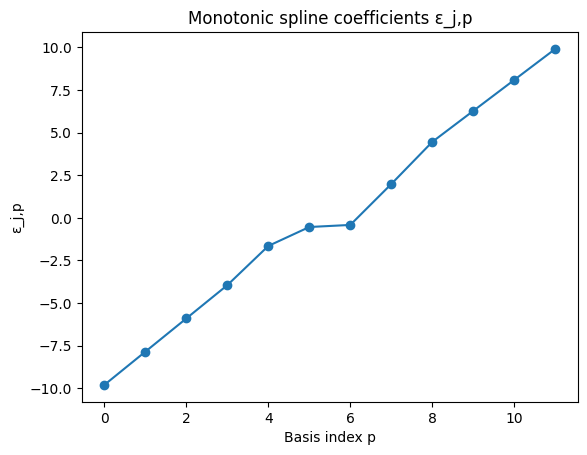

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.8756, -7.8952, -5.4721, -3.5298, -1.8232, -0.8442, -0.0464,  1.5377,
         2.2307,  2.8346,  3.4507,  4.0739])


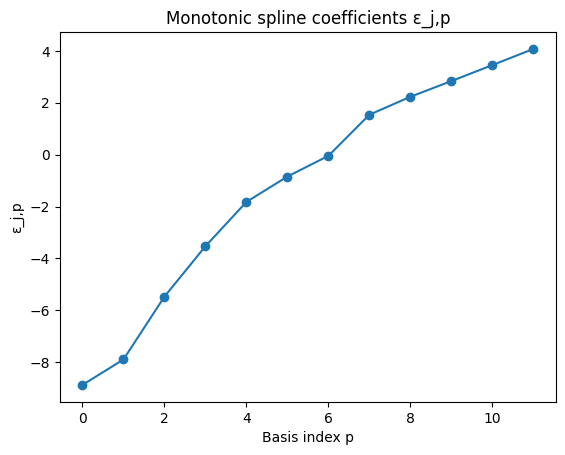

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-9.9953, -8.1812, -6.3671, -4.5526, -2.6497, -0.4659,  0.8652,  3.4521,
         5.2996,  7.1178,  8.9360, 10.7542])


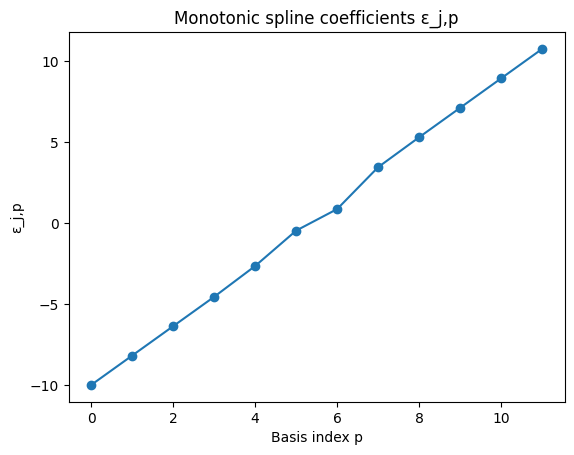

dict_keys(['transformation.params.0', 'transformation.params.1'])
True
tensor([-8.8913, -7.9887, -5.6908, -3.9622, -2.3363, -0.5140,  1.0426,  1.9836,
         2.6268,  3.2407,  3.8404,  4.4212])


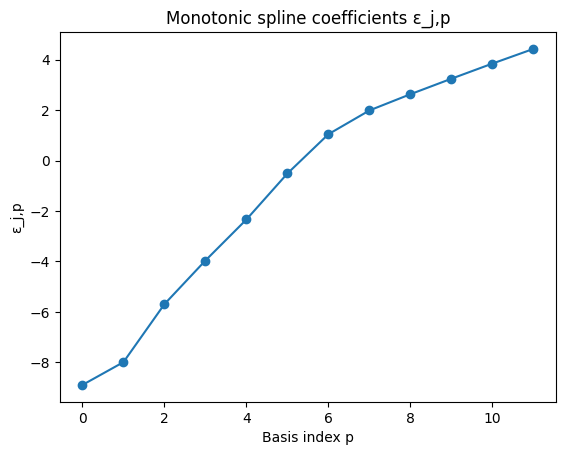

In [45]:
sanity_check(model_freq, transformation_grad=0)
sanity_check(model, transformation_grad=0)
sanity_check(model_freq, transformation_grad=1)
sanity_check(model, transformation_grad=1)

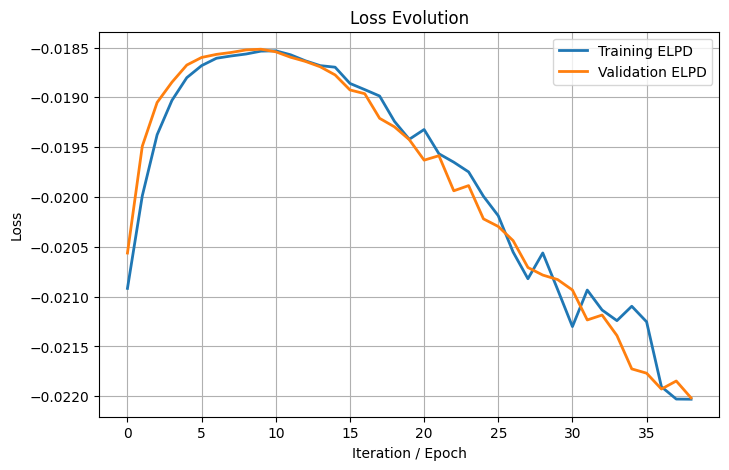

In [46]:
loss_history = output['ll_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training ELPD", linewidth=2)
plt.plot(val_loss, label="Validation ELPD", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [48]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
#print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
#print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.4653
KLD GTM      Train Data:  0.1656
KLD Copula   Train Data:  0.5433

KLD BGTM      Test  Data:  0.4649
KLD GTM      Test  Data:  0.1703
KLD Copula   Test  Data:  0.5359


In [49]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

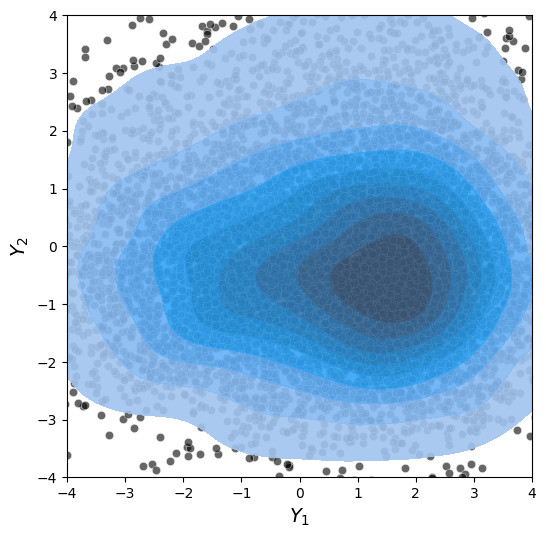

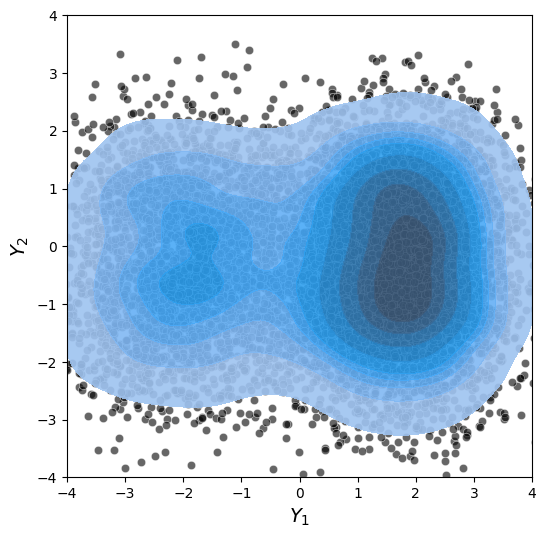

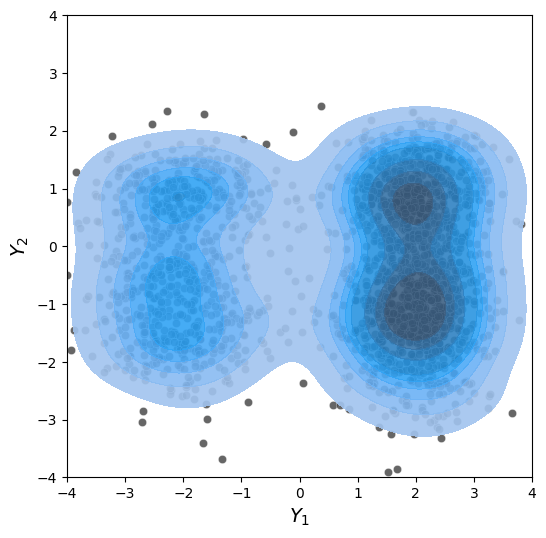

In [50]:
model.plot_densities(synthetic_samples.cpu().numpy(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])